<a href="https://colab.research.google.com/github/AmoguJUduka/MachineLearning/blob/main/DeepLearningAssignments/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview**:

In this assignment, I experiment with Convolutional Neural Networks (CNNs) using the CIFAR-10 dataset to explore the concepts of underfitting, overfitting, and appropriate model complexity.

For this goal, I compute the number of parameters to be trained in a CNN model. I also compare different CNN architectures and summarize key design ideas.  

**Dataset**:

I used the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

**Tools**: PyTorch

**Using the required CPU**

In [1]:
# check the pytorch version and the availability of cuda
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.4.1+cu121
True


**Basic AlexNet**

AlexNet is the name of the convolutional neural network (CNN) designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton at the university of Toronto, the CNN competed in the imagenet challenge on September 30, 2012.

The network influential nature came from it’s use of GPU to accelerate deep learning, even though it was not the first to do so nonetheless the AlexNet paper was cited over 80,00 times influencing many other papers and research into using GPUs to accelerate deep learning.

In [2]:
import torch.nn as nn

'''
modified to fit dataset size
'''
NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

net = AlexNet()

**Loading the CIFAR-10 dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into training batches (40,000), validation batche (10,000) and test batche(10,000).

In [3]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define the transformation for CIFAR-10 dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Split the training set into 80% training and 20% validation
train_size = int(0.8 * len(trainset))  # 80% of the data for training
val_size = len(trainset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])


# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# Load the CIFAR-10 test dataset

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's inspect some of the training images

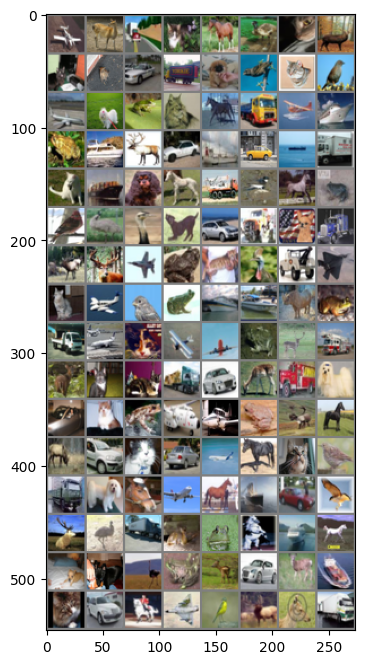

In [5]:
# functions to show an image

plt.figure(figsize=(10, 8))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**Define a Loss function and Optimizer**

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

**Model Performance without Hyper-parameter tuning**

In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() * images.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)  # Get class with highest score
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
            total_predictions += labels.size(0)  # Total labels in batch

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions * 100  # Accuracy in percentage

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Example of calling the function
train_model(net, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 2.3027, Accuracy: 9.92%
Epoch [2/10], Loss: 2.3025, Accuracy: 10.03%
Epoch [3/10], Loss: 2.3025, Accuracy: 10.07%
Epoch [4/10], Loss: 2.3023, Accuracy: 10.55%
Epoch [5/10], Loss: 2.3022, Accuracy: 10.84%
Epoch [6/10], Loss: 2.3021, Accuracy: 11.28%
Epoch [7/10], Loss: 2.3019, Accuracy: 11.44%
Epoch [8/10], Loss: 2.3016, Accuracy: 12.05%
Epoch [9/10], Loss: 2.3012, Accuracy: 13.18%
Epoch [10/10], Loss: 2.3007, Accuracy: 13.94%


In [8]:
# Model evaluation
def evaluate_model(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = correct / total
    print(f"Validation Accuracy: {val_accuracy:.4f}")


# Evaluate the model
evaluate_model(net, val_loader)

Validation Accuracy: 0.1405


This model was trained on our datatset for 10 epochs, the training loss were unstable with a score around 58%. During the model evaluation, this model reached an accuracy score of 49%, which is quite low. By leveraging this model parameter with hyper-parameter tuning, we could potentially acheive more satisfactory results.

**Hyperparameter tuning with Sktorch**

Skorch  is a Python library that facilitates seamless integration between PyTorch and scikit-learn, enabling the use of PyTorch models within scikit-learn’s ecosystem. One of its key features is the ability to perform hyperparameter tuning using scikit-learn’s GridSearchCV.



In [9]:
# Wrap the Pytorch model with Skorch
!pip install skorch # Install the 'skorch' library which provides NeuralNetClassifier

In [10]:
from skorch import NeuralNetClassifier

# Define the neural network model
net = NeuralNetClassifier(
    module=net,  # Your PyTorch model class (SimpleModel in this case)
    module__num_classes=NUM_CLASSES,  # A keyword argument passed to the module (SimpleModel)
    criterion=nn.CrossEntropyLoss,  # Loss function used for classification tasks
    optimizer=optim.Adam,  # The optimizer (Adam in this case)
    optimizer__lr=0.001,  # Learning rate for the optimizer
    batch_size=32,  # Batch size for training
    max_epochs=10  # Number of epochs to train the model
)


This code specifies a way to define and train a neural network model for classification tasks using Skorch.



For this image classfication task, we are tuning the following parameters:

**Dropout rate**: specifies the dropout rate of the neural network model to prevent overfitting

**Kernel size**: defines the kernel size of the convolutional layers in our neural network model

**last_units**: specifies the number of units (neurons) in the last fully connected layer of our neural network model.

In [11]:
params = {
    'module__dropout': [0.1, 0.4, 0.6],
    'module__conv_kernel_size': [2,3,4],
    'module__last_units': [64, 128]

}

To fit the data for grid search using GridSearchCV with the PyTorch model wrapped in Skorch, we need to ensure that the input format is correct for Scikit-learn's GridSearchCV.

Skorch provides a bridge between PyTorch models and Scikit-learn, allowing you to use Scikit-learn tools like grid search.

In [12]:
import numpy as np

# Function to convert DataLoader to numpy arrays for X and y
def dataloader_to_numpy(dataloader):
    X_list = []
    y_list = []
    for images, labels in dataloader:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())

    # Concatenate all batches to form the full dataset
    X_np = np.concatenate(X_list)
    y_np = np.concatenate(y_list)
    return X_np, y_np

# Convert train_loader to numpy arrays
X_train, y_train = dataloader_to_numpy(train_loader)
X_val, y_val = dataloader_to_numpy(val_loader)
X_test, y_test = dataloader_to_numpy(test_loader)

In [13]:
"""

# Performing grid search
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV

# Perform grid search with cross-validation
gs = GridSearchCV(net, params, cv=3, scoring='accuracy', verbose=1)

# Train the model
gs.fit(X_train, y_train)
"""

"\n\n# Performing grid search\nfrom sklearn.model_selection import GridSearchCV  # Import GridSearchCV\n\n# Perform grid search with cross-validation\ngs = GridSearchCV(net, params, cv=3, scoring='accuracy', verbose=1)\n\n# Train the model\ngs.fit(X_train, y_train)\n"

In [14]:
"""
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)
"""

'\nprint("Best parameters found: ", gs.best_params_)\nprint("Best accuracy found: ", gs.best_score_)\n'